In [1]:
# Financial Chatbot Project - Jay D. Vaidya

In [2]:
# Import initial packages to be used

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import numpy as np
import pandas as pd
import random
import string # to process standard python strings
import wikipedia
import gensim
import itertools
import re
import wget
import pprint as pp
import seaborn as sns
import pickle 
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/home/jayvaidya/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
# ensure both the 'punkt' and 'wordnet' packages are available; only needs to occur once

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jayvaidya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jayvaidya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Test out the wikipedia module by first printing the summary of what python is
print(wikipedia.summary("Python Programming Language"))

Python is a high-level, interpreted, general-purpose programming language. Its design philosophy emphasizes code readability with the use of significant indentation.Python is dynamically-typed and garbage-collected. It supports multiple programming paradigms, including structured (particularly procedural), object-oriented and functional programming. It is often described as a "batteries included" language due to its comprehensive standard library.Guido van Rossum began working on Python in the late 1980s as a successor to the ABC programming language and first released it in 1991 as Python 0.9.0. Python 2.0 was released in 2000 and introduced new features such as list comprehensions, cycle-detecting garbage collection, reference counting, and Unicode support. Python 3.0, released in 2008, was a major revision that is not completely backward-compatible with earlier versions. Python 2 was discontinued with version 2.7.18 in 2020.Python consistently ranks as one of the most popular progra

In [6]:
# Test out the search function provided by the wikipedia module
wikipedia.search("interest rate")

['Interest rate',
 'Compound interest',
 'Interest',
 'Real interest rate',
 'Nominal interest rate',
 'Neutral rate of interest',
 'Interest rate risk',
 'Interest rate swap',
 'Effective interest rate',
 'Interest rate parity']

In [7]:
# Generate a list of the terms to be searched for in wikipedia; together, this list of terms will help generate the corpus of text
search_list= ['interest rate', 'income statement', 'balance sheet', 'statement of cash flows', 'personal income', 'personal budget', 
              'assets', 'liabilities', 'shareholder equity', 'annual percentage rate', 'stock', 'bond (finance)', 'mutual fund', 'discount rate', 'mortgage loan']

# Create an empty list, to which we will append the names of the wikipedia search terms we identify
big_results_list = []

# Search for the names in the "search_list" and append the top 2 hits for each search terms to the "big_results_list"
for search_term in search_list:
    current_results_list = wikipedia.search(search_term)[0:2]
    big_results_list.append(current_results_list)

# Flatten the list 
big_results_list = list(itertools.chain(*big_results_list))    

# print out the list of topics pulled from the wikipedia search terms
print(big_results_list)

# Create an empty list, to which we will apend the content from the wikipedia pages we identified above
big_wiki_search_results = []

# loop through the list of results and collect the pertinent content and other meta-data from wikipedia, generating a dict of information for each result
for each_result in big_results_list:
    try:
        wiki_page_result = {}
        wiki_page_obj = wikipedia.page(each_result)
        wiki_page_result['title'] = wiki_page_obj.title
        wiki_page_result['content'] = wiki_page_obj.content
        wiki_page_result['url'] = wiki_page_obj.url
        wiki_page_result['links'] = wiki_page_obj.links
        big_wiki_search_results.append(wiki_page_result)

    # Generate exceptions for the anticipated potential errors, and have the loop continue
    except wikipedia.exceptions.PageError:
        continue
    except wikipedia.exceptions.DisambiguationError:
        continue 

['Interest rate', 'Compound interest', 'Income statement', 'Financial statement', 'Balance sheet', 'Off-balance-sheet', 'Cash flow statement', 'Free cash flow', 'Personal income', 'State income tax', 'Personal budget', 'Budget', 'Asset', 'Assets under management', 'Liability', 'Liability (financial accounting)', 'Equity (finance)', 'Return on equity', 'Annual percentage rate', 'Annual percentage yield', 'Stock', 'Nasdaq', 'Bond (finance)', 'Trader (finance)', 'Mutual fund', 'SBI Mutual Fund', 'Discount rate', 'Discounting', 'Mortgage loan', 'Adjustable-rate mortgage']


In [8]:
# View the flattened list of results
big_results_list

['Interest rate',
 'Compound interest',
 'Income statement',
 'Financial statement',
 'Balance sheet',
 'Off-balance-sheet',
 'Cash flow statement',
 'Free cash flow',
 'Personal income',
 'State income tax',
 'Personal budget',
 'Budget',
 'Asset',
 'Assets under management',
 'Liability',
 'Liability (financial accounting)',
 'Equity (finance)',
 'Return on equity',
 'Annual percentage rate',
 'Annual percentage yield',
 'Stock',
 'Nasdaq',
 'Bond (finance)',
 'Trader (finance)',
 'Mutual fund',
 'SBI Mutual Fund',
 'Discount rate',
 'Discounting',
 'Mortgage loan',
 'Adjustable-rate mortgage']

In [9]:
# Check the length of the list; this indicates the number of initial documents to be part of the corpus; each document will subsequently be broken up further
len(big_wiki_search_results)

26

In [12]:
# View the first entry in the results list to understand the format of the data just pulled in from wikipedia
big_wiki_search_results[0]

{'title': 'Interest rate',
 'content': 'An interest rate is the amount of interest due per period, as a proportion of the amount lent, deposited, or borrowed (called the principal sum). The total interest on an amount lent or borrowed depends on the principal sum, the interest rate, the compounding frequency, and the length of time over which it is lent, deposited, or borrowed.\nThe annual interest rate is the rate over a period of one year. Other interest rates apply over different periods, such as a month or a day, but they are usually annualized.\nThe interest rate has been characterized as "an index of the preference . . . for a dollar of present [income] over a dollar of future income." The borrower wants, or needs, to have money sooner rather than later, and is willing to pay a fee—the interest rate—for that privilege.\n\n\n== Influencing factors ==\nInterest rates vary according to:\n\nthe government\'s directives to the central bank to accomplish the government\'s goals\nthe cu

In [13]:
# Use pandas to convert the list of dicts into a dataframe in order to begin cleaning and processing the text
big_wiki_df = pd.DataFrame.from_dict(big_wiki_search_results)
big_wiki_df

,title,content,url,links
0,Interest rate,An interest rate is the amount of interest due...,https://en.wikipedia.org/wiki/Interest_rate,"[AD–AS model, Abba P. Lerner, Accelerator effe..."
1,Compound interest,Compound interest is the addition of interest ...,https://en.wikipedia.org/wiki/Compound_interest,"[Accumulation function, Actuarial notation, Am..."
2,Income statement,An income statement or profit and loss account...,https://en.wikipedia.org/wiki/Income_statement,"[Absorption costing, Accountant, Accounting, A..."
3,Financial statement,Financial statements (or financial reports) ar...,https://en.wikipedia.org/wiki/Financial_statement,"[Account (accountancy), Accountable Fundraisin..."
4,Balance sheet,"In financial accounting, a balance sheet (also...",https://en.wikipedia.org/wiki/Balance_sheet,"[Accountant, Accounting, Accounting equation, ..."
5,Off-balance-sheet,"Off-balance sheet (OBS), or incognito leverage...",https://en.wikipedia.org/wiki/Off-balance-sheet,"[Accountant, Accounting, Accounting networks a..."
6,Free cash flow,"In corporate finance, free cash flow (FCF) or ...",https://en.wikipedia.org/wiki/Free_cash_flow,"[Accretion/dilution analysis, Adjusted present..."
7,Personal income,"In economics, personal income refers to an ind...",https://en.wikipedia.org/wiki/Personal_income,"[996 working hour system, Academic tenure, Acc..."
8,State income tax,In addition to federal income tax collected by...,https://en.wikipedia.org/wiki/State_income_tax,"[2012 California Proposition 30, 9–9–9 Plan, A..."
9,Personal budget,A personal budget (for the budget of one perso...,https://en.wikipedia.org/wiki/Personal_budget,"[Bank, Bankruptcy, Basic necessities, Car loan..."


In [14]:
# For potential user responses, we should replace some words that are semantically equivalent, but have
# multiple different spellings or references in the text. This should help enable better matching with the TF-IDF vectorization and cosine similarity approaches

# initializing word list 
interest_word_list = ['interest', 'interest rates', 'rates', 'int', 'rate']
income_statement_word_list = ['income stmt', 'IS']
balance_sheet_word_list = ['BS']
APR_word_list = ['APR']
mortgage_word_list = ['mortgage']

# initializing replacement word 
interest_repl_wrd = 'interest rate'
income_statement_repl_wrd = 'income statement'
balance_sheet_repl_wrd = 'balance sheet'
APR_repl_wrd = 'annual percentage rate'
mortgage_repl_wrd = 'mortgage loan'

In [15]:
# Phase one cleaning entails removal of some items that may skew results, such as line breaks and heading markers
def clean_doc_phase_one(doc): 
    #split document into individual words
    tokens=doc.split()
    
    # filter out tokens denoting a page break 
    tokens = [re.sub("\n", "", w) for w in tokens]
    
    # filter out tokens denoting a heading and replace them with a period, in order that they be segmented into their own sentences (and later removed for being too short)
    tokens = [re.sub("==", ".", w) for w in tokens]
    return tokens
    
def clean_doc_phase_two(doc):
    #split document into individual words
    tokens=doc.split()
    
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    
    # Replace multiple words using list comprehension
    tokens = [interest_repl_wrd if idx in interest_word_list else idx for idx in tokens]
    tokens = [income_statement_repl_wrd if idx in income_statement_word_list else idx for idx in tokens]
    tokens = [balance_sheet_repl_wrd if idx in balance_sheet_word_list else idx for idx in tokens]
    tokens = [APR_repl_wrd if idx in APR_word_list else idx for idx in tokens]
    tokens = [mortgage_repl_wrd if idx in mortgage_word_list else idx for idx in tokens]
    
    # set tokens to lower case
    tokens = [word.lower() for word in tokens]
    
    # Lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(w) for w in tokens]
    
    cleaned_sent = ' '.join(tokens)
    return cleaned_sent

In [16]:
# print stopwords and review the list; determine if any words should be added
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [17]:
# Apply phase one document cleaning and then append the lightly cleaned docs back to a list for subsequent tokenization
cleaned_docs_phase_one = []
for i in range(len(big_wiki_df['content'])):
    cleaned_doc = clean_doc_phase_one(big_wiki_df['content'][i])
    cleaned_doc = ' '.join(cleaned_doc)
    cleaned_docs_phase_one.append(cleaned_doc)

In [18]:
# Apply the sentence tokenizer; by tokenizing sentences, we can later treat each sentence like its' own document for matching documents with questions posed to the chatbot
cleaned_sent_tokens = []
for i in range(len(cleaned_docs_phase_one)):
    sent_tokens = nltk.sent_tokenize(cleaned_docs_phase_one[i])
    cleaned_sent_tokens.append(sent_tokens)

In [19]:
# Flatten the lis of lists of sentences, then check the length of the new object; the length denotes the number of "documents" in our new corpus
flat_cleaned_sent_tokens = [sent for sublist in cleaned_sent_tokens for sent in sublist]
len(flat_cleaned_sent_tokens)

3043

In [20]:
# View a small slice of the new object containing the list of sentences derived from the corpus
flat_cleaned_sent_tokens[:20]

['An interest rate is the amount of interest due per period, as a proportion of the amount lent, deposited, or borrowed (called the principal sum).',
 'The total interest on an amount lent or borrowed depends on the principal sum, the interest rate, the compounding frequency, and the length of time over which it is lent, deposited, or borrowed.',
 'The annual interest rate is the rate over a period of one year.',
 'Other interest rates apply over different periods, such as a month or a day, but they are usually annualized.',
 'The interest rate has been characterized as "an index of the preference .',
 '.',
 '.',
 'for a dollar of present [income] over a dollar of future income."',
 'The borrower wants, or needs, to have money sooner rather than later, and is willing to pay a fee—the interest rate—for that privilege.',
 '.',
 'Influencing factors .',
 "Interest rates vary according to: the government's directives to the central bank to accomplish the government's goals the currency of 

In [21]:
# Eliminate all sentences with 5 or fewer words; the length of this new object will represent the size of the winnowed corpus
flat_cleaned_sent_tokens = [sent for sent in flat_cleaned_sent_tokens if len(sent.split()) > 5]
len(flat_cleaned_sent_tokens)

2555

In [19]:
# Let's now explore the corpus further using knowledge graphs

In [22]:
# Instantiate Spacy's English pipeline optimized for CPU
nlp = spacy.load('en_core_web_sm')

# Generate the function for entity extraction
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [23]:
#entity pair extraction from corpus
entity_pairs = []

for i in tqdm(flat_cleaned_sent_tokens):
    entity_pairs.append(get_entities(i))

100%|██████████| 2555/2555 [00:10<00:00, 253.24it/s]


In [24]:
# view of slice of the entity pairs object
entity_pairs[:5]

[['interest rate', 'due  amount'],
 ['principal compounding it', 'principal compounding which'],
 ['annual interest rate', 'one  year'],
 ['such  they', 'such  month'],
 ['interest rate', 'preference']]

In [25]:
# Define a function to generate relational pattern matches
def get_relation(sent):
    try:
        doc = nlp(sent)
        # Matcher class object 
        matcher = Matcher(nlp.vocab)
        #define the pattern 
        pattern = [{'DEP':'ROOT'}, 
                {'DEP':'prep','OP':"?"},
                {'DEP':'agent','OP':"?"},  
                {'POS':'ADJ','OP':"?"}] 
        matcher.add("matching_1", [pattern]) 
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]] 
        return(span.text)
    except:
        pass

In [26]:
relations = []

for i in flat_cleaned_sent_tokens:
    relations.append(get_relation(i))

In [27]:
# Display the counts for relations generated by the above functions
print(pd.Series(relations).value_counts()[:20])

is             300
are            103
have            51
has             41
include         39
be              36
called          21
means           19
known as        18
used            18
announced       17
includes        16
was             16
were            14
referred to     13
require         13
use             13
e.g.            13
been            12
required        12
dtype: int64


In [28]:
#extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

# Generate a dataframe of the source, target and edge connnecting the two 
kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [29]:
# View the head of the new dataframe
kg_df.head(10)

,source,target,edge
0,interest rate,due amount,is
1,principal compounding it,principal compounding which,depends on
2,annual interest rate,one year,is
3,such they,such month,apply over different
4,interest rate,preference,characterized as
5,,future income,for
6,borrower,rather interest privilege,wants
7,central currency,other provisions reserve factors,vary according
8,company,business,borrows
9,bank,company interest,charges


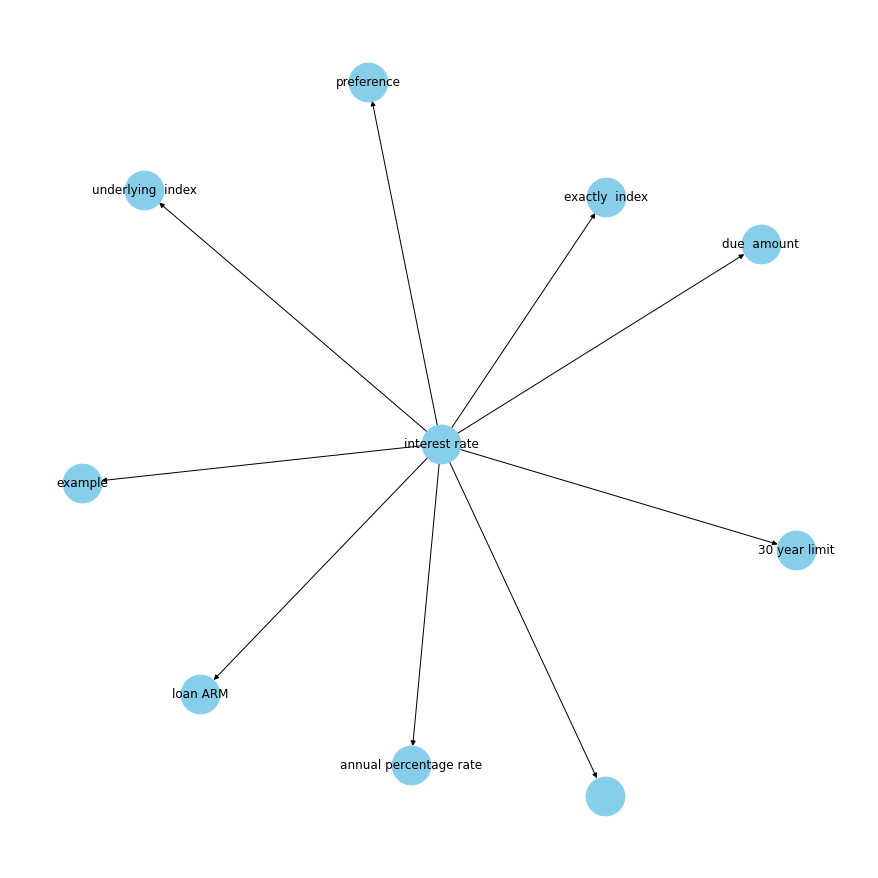

In [30]:
# Instead of filtering the pairs by "edge", I will now filter by "source"

G=nx.from_pandas_edgelist(kg_df[kg_df['source']=="interest rate"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

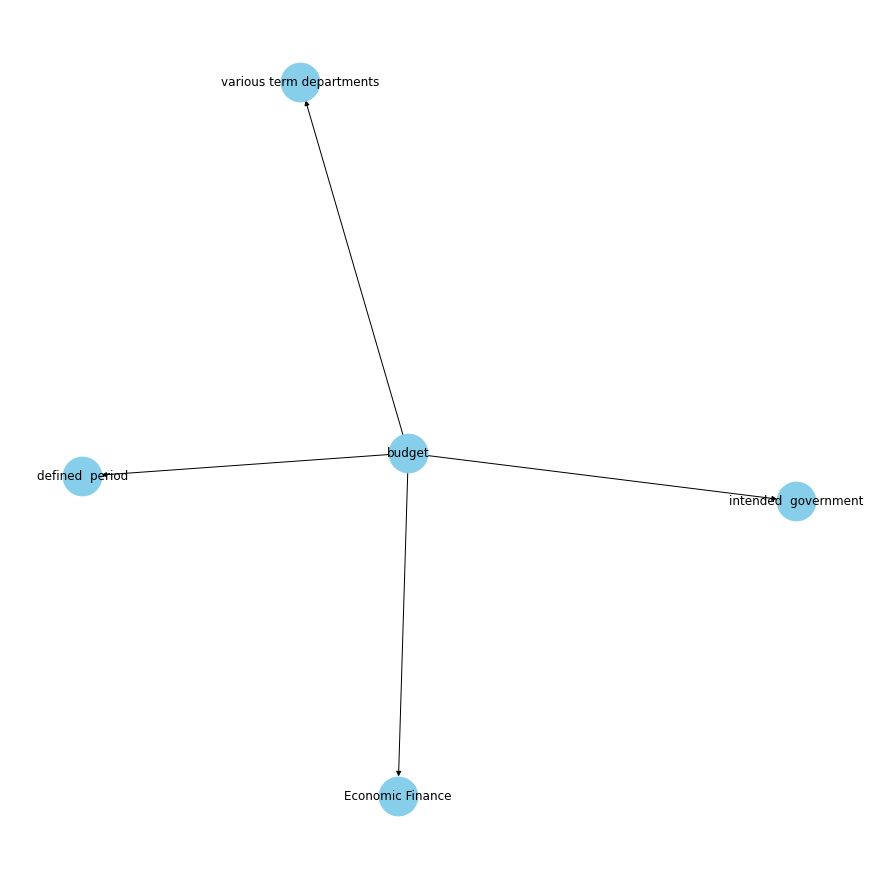

In [31]:
G=nx.from_pandas_edgelist(kg_df[kg_df['source']=="budget"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

## I will now turn my attention towards generating the chatbot - several different approaches will be employed, compared and contrasted

In [33]:
# Generate some standard greeting inputs to which the chatbot should respond; also generate typical responses from which the chatbot can randomly select, for a given greeting 
greeting_inputs = ("hey", "good morning", "good evening", "morning", "evening", "hi", "whatsup")
greeting_responses = ["hey", "Hey there", "*nods*", "hello, what can I answer for you today?", "hello", "Welcome, what question(s) do you have for me?"]

def generate_greeting_response(greeting):
    for token in greeting.split():
        if token.lower() in greeting_inputs:
            return random.choice(greeting_responses)

# Below code originally sourced from: https://medium.com/analytics-vidhya/building-a-simple-chatbot-in-python-using-nltk-7c8c8215ac6e

def response_tfidf(user_response):
    robo_response=''
    sent_tokens = flat_cleaned_sent_tokens.copy()
    sent_tokens.append(user_response)
    
    TfidfVec = TfidfVectorizer(stop_words='english')
    tfidf = TfidfVec.fit_transform(sent_tokens)
    vals = cosine_similarity(tfidf[-1], tfidf)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    
    if(req_tfidf==0):
        robo_response=robo_response+"I am sorry! I don't understand your question, can you try to pose it in a different manner?"
        return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response
    
    sent_tokens = flat_cleaned_sent_tokens.copy()

In [34]:
# Generate functions that handle the core dialogue and response mechanisms for the chatbot

continue_dialogue = True
print("""Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye'""", ":")
while(continue_dialogue == True):
    human_text = input()
    # Used the phase two clean doc function, from above, to distill user questions to the essence, as best as possible
    human_text = clean_doc_phase_two(human_text)
    
    if human_text != 'bye':
        if human_text == 'thanks' or human_text == 'thank you very much' or human_text == 'thank you':
            continue_dialogue = False
            print("FinanceBot: You are welcome")
        else:
            if generate_greeting_response(human_text) != None:
                print("FinanceBot: " + generate_greeting_response(human_text))
            else:
                print("FinanceBot: ", end="")
                print(response_tfidf(human_text))

    else:
        continue_dialogue = False
        print("FinanceBot: Good bye and take care of yourself.")

Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye' :


 What is an interest rate?


FinanceBot: The annual interest rate is the rate over a period of one year.


 how do I get a mortgage?


FinanceBot: Other forms of mortgage loan include the interest-only mortgage, the fixed-rate mortgage, the negative amortization mortgage, and the balloon payment mortgage.


 What is a mutual fund?


FinanceBot: Some of the major competitors for SBI Mutual Fund in the mutual fund sector are Axis Mutual Fund, Birla Sun Life Mutual Fund, HDFC Mutual Fund, ICICI Prudential Mutual Fund, Kotak Mutual Fund, Nippon India Mutual Fund and UTI Mutual Fund .


 What is an asset?


FinanceBot: .= Wasting asset .= A wasting asset is an asset that irreversibly declines in value over time.


 bye


FinanceBot: Good bye and take care of yourself.


## Let's switch gears and generate chatbot responses based on Doc2Vec embeddings; otherwise, the approach will remain unchanged. We can then compare the quality of chatbot responses for the TF-IDF and Doc2Vec methods

In [35]:
# Produce the Doc2Vec embedding vectors for each of the documents in the corpus

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(flat_cleaned_sent_tokens)]
model = Doc2Vec(documents, vector_size=100, window=5, min_count=1, workers=24)

doc2vec_df=pd.DataFrame()
for i in range(0,len(flat_cleaned_sent_tokens)):
    vector=pd.DataFrame(model.infer_vector(flat_cleaned_sent_tokens[i].split())).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc2vec_df=doc2vec_df.drop('index', axis=1)

doc2vec_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.004090,0.019232,0.012705,0.013251,0.007421,0.017970,0.016227,0.002663,-0.016194,0.011375,...,-0.002282,-0.007544,-0.006145,-0.010440,-0.017670,-0.004345,0.009935,0.000047,0.012234,0.002880
1,-0.004171,-0.004401,0.004816,0.003058,0.004917,-0.000817,-0.000942,0.002108,0.002773,-0.003150,...,-0.002371,-0.002544,0.004950,-0.000236,0.004295,-0.004584,-0.004712,-0.000483,0.003563,-0.000013
2,-0.003681,-0.002203,-0.002789,-0.001042,-0.000925,-0.004767,-0.003527,0.004880,-0.003974,-0.002328,...,0.001982,-0.001892,0.003576,0.004510,0.003139,0.004769,-0.002248,-0.003439,0.001168,-0.004024
3,-0.007389,0.012222,0.006831,0.002614,0.003020,0.008508,0.005621,0.001938,-0.007769,0.001874,...,-0.005612,-0.003922,-0.003164,-0.000762,-0.012867,-0.002525,0.002689,0.000583,0.004542,0.001473
4,-0.049590,0.082863,0.037820,0.051986,0.036365,0.084841,0.070154,0.012104,-0.070596,0.017042,...,-0.011877,-0.043367,-0.036684,-0.036650,-0.078527,-0.036805,0.048716,0.004506,0.057967,0.058143
5,-0.020116,0.040736,0.019298,0.016794,0.006992,0.027079,0.030116,0.004117,-0.026123,0.016594,...,-0.004260,-0.020974,-0.009926,-0.015794,-0.035579,-0.016291,0.020456,-0.003217,0.021652,0.019986
6,-0.006933,0.018343,0.011581,0.008872,0.000897,0.020545,0.014437,0.003881,-0.017216,0.005460,...,-0.003838,-0.013004,-0.009488,-0.006541,-0.020790,-0.007016,0.009549,0.002903,0.017711,0.013057
7,0.001220,0.002950,-0.002582,-0.000688,0.000545,0.001629,-0.001395,0.004337,0.001285,-0.000609,...,0.001914,0.003071,-0.000783,0.003352,-0.000106,-0.001590,-0.003260,0.004795,0.003830,0.001548
8,-0.053229,0.076019,0.023904,0.035711,0.014809,0.076815,0.062070,-0.001098,-0.069140,0.026751,...,-0.027685,-0.030242,-0.016496,-0.010987,-0.064985,-0.030127,0.027801,0.019878,0.048767,0.038598
9,-0.003400,-0.004517,-0.004664,0.001144,-0.002758,-0.004615,0.000725,0.002158,-0.001373,-0.002983,...,-0.004408,-0.004708,0.003057,-0.004262,-0.003609,0.000850,0.001644,0.001726,0.001049,-0.003782


In [36]:
#implementation of silhouette score to measure the optimal number of clusters

k_list = [2, 5, 7, 10, 15, 20]

#silhoutte score list
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state =89)
    km.fit(doc2vec_df)
    labels = km.labels_.tolist()
    score = silhouette_score(doc2vec_df, labels)
    sil_scores.append(score)

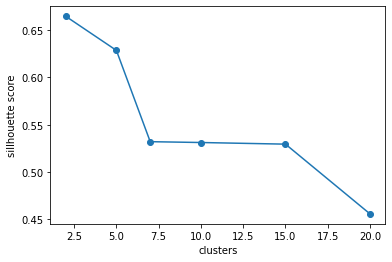

In [37]:
#plot silhouette scores in chart

%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("sillhouette score")
plt.show()

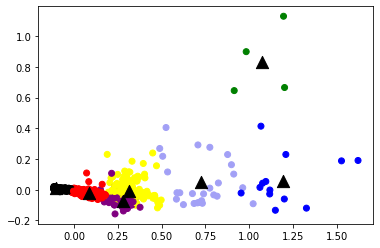

In [38]:
# Generate a 2-D plot of document clusters (using PCA to reduce to two dimensions) and using the optimal number of clusters determined above

kmeans_model = KMeans(n_clusters=7, init='k-means++', max_iter=100) 
X = kmeans_model.fit(doc2vec_df)
labels=kmeans_model.labels_.tolist()

l = kmeans_model.fit_predict(doc2vec_df)
pca = PCA(n_components=2).fit(doc2vec_df)
datapoint = pca.transform(doc2vec_df)
plt.figure
label1 = ['#000000', '#FFFF00', '#008000', '#0000FF', '#800080', '#FF0000', '#a2a0f6']
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans_model.cluster_centers_
centroidpoint = pca.transform(centroids)

plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

In [39]:
# Define the funtion that will generate the chatbot response for the Doc2Vec methodology

def response_doc2vec(user_response):
    robo_response=''
    sent_tokens = flat_cleaned_sent_tokens.copy()
    doc_embeddings = doc2vec_df.copy()
    new_embedding_vector=pd.DataFrame(model.infer_vector(user_response.split())).transpose()
    doc_embeddings = pd.concat([doc_embeddings, new_embedding_vector], axis=0)

    
    vals_cos = cosine_similarity(doc_embeddings[-1:], doc_embeddings)

    idx=vals_cos.argsort()[0][-2]
    flat = vals_cos.flatten()
    flat.sort()
    req_doc2vec = flat[-2]
    
    if(req_doc2vec==0):
        robo_response=robo_response+"I am sorry! I don't understand your question, can you try to pose it in a different manner?"
        return robo_response
    else:
        robo_response = robo_response+sent_tokens[idx]
        return robo_response
    
    sent_tokens = flat_cleaned_sent_tokens.copy()
    doc_embeddings = doc2vec_df.copy()

In [40]:
# Test the new function to see that it is working
response_doc2vec("personal budget")

'.= Compounding basis .= To convert an interest rate from one compounding basis to another compounding basis, use where r1 is the interest rate with compounding frequency n1, and r2 is the interest rate with compounding frequency n2.'

In [41]:
# Generate functions that handle the core dialogue and response mechanisms for the chatbot

continue_dialogue = True
print("""Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye'""", ":")
while(continue_dialogue == True):
    human_text = input()
    # Used the phase two clean doc function, from above, to distill user questions to the essence, as best as possible
    human_text = clean_doc_phase_two(human_text)
    
    if human_text != 'bye':
        if human_text == 'thanks' or human_text == 'thank you very much' or human_text == 'thank you':
            continue_dialogue = False
            print("FinanceBot: You are welcome")
        else:
            if generate_greeting_response(human_text) != None:
                print("FinanceBot: " + generate_greeting_response(human_text))
            else:
                print("FinanceBot: ", end="")
                print(response_doc2vec(human_text))

    else:
        continue_dialogue = False
        print("FinanceBot: Good bye and take care of yourself.")

Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye' :


 Can you tell me what an interest rate is?


FinanceBot: (IAS 8) No items may be presented in the income statement as extraordinary items under IFRS regulations, but are permissible under US GAAP.


 How do I create a personal budget?


FinanceBot: The gain from selling assets generated when the price you sell it for is higher than the price you paid for it.Advantages of Portfolio Income:• You can use other people's time (research/data) and money (leveraged investments or margin trading accounts) • You have more control over where and when you invest your time/money than you do with earned income.


 What is an asset?


FinanceBot: The Strictly Stock division was put on hold as American automobile manufacturers were unable to produce family sedans quickly enough to keep up with post-World War II demand.


 bye


FinanceBot: Good bye and take care of yourself.


## Time to switch tactics again. This time, we will use word-level embeddings with a pretrained 100-dimensional GloVe embedding to find document similarities

In [42]:
# Set memory growth to true to enable proper functioning of GPUs
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

In [43]:
# code sourced from: https://towardsdatascience.com/calculating-document-similarities-using-bert-and-other-models-b2c1a29c9630

flat_cleaned_sent_tokens_p2 = []
for sent in flat_cleaned_sent_tokens:
    clean_sent = clean_doc_phase_two(sent)
    flat_cleaned_sent_tokens_p2.append(clean_sent)
    
documents_df=pd.DataFrame(flat_cleaned_sent_tokens_p2,columns=['flat_cleaned_sent_tokens'])

# reading Glove word embeddings into a dictionary with "word" as key and values as word vectors
embeddings_index = dict()

with open('/home/jayvaidya/Documents/MSDS453/Final Project/glove.6B/glove.6B.100d.txt') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create a doc2vec function that sums the individual word-level embeddings for a given document, producing a document-level score
def doc2vecFunct(doc):
    vdoc = [embeddings_index.get(x,0) for x in doc.lower().split(" ")]
    doc2vec = np.sum(vdoc, axis = 0)
    if np.sum(doc2vec == 0) ==1:
        doc2vec = np.zeros(100, "float32")

    return doc2vec

# Convert each document into a document embedding using the function just defined above
data = []
for i in documents_df['flat_cleaned_sent_tokens']:
    data.append(doc2vecFunct(i))

doc_embd = pd.DataFrame(data)
doc_embd.shape

(2555, 100)

In [44]:
# Define the response function using the GLoVE embedding vectors

def response_glove(user_response):
    robo_response=''
    sent_tokens = flat_cleaned_sent_tokens_p2.copy()
    sent_tokens.append(clean_doc_phase_two(user_response))
    
    data = []
    for i in sent_tokens:
        data.append(doc2vecFunct(i))
    
    vals = cosine_similarity([data[-1]], data)
    idx=vals.argsort()[0][-2]
    flat = vals.flatten()
    flat.sort()
    req_tfidf = flat[-2]
    
    if(req_tfidf==0):
        robo_response=robo_response+"I am sorry! I don't understand your question, can you try to pose it in a different manner?"
        return robo_response
    else:
        robo_response = robo_response+flat_cleaned_sent_tokens[idx]
        return robo_response
    
    sent_tokens = flat_cleaned_sent_tokens.copy()

In [46]:
# Generate functions that handle the core dialogue and response mechanisms for the chatbot

continue_dialogue = True
print("""Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye'""", ":")
while(continue_dialogue == True):
    human_text = input()
    # Used the phase two clean doc function, from above, to distill user questions to the essence, as best as possible
    human_text = clean_doc_phase_two(human_text)
    
    if human_text != 'bye':
        if human_text == 'thanks' or human_text == 'thank you very much' or human_text == 'thank you':
            continue_dialogue = False
            print("FinanceBot: You are welcome")
        else:
            if generate_greeting_response(human_text) != None:
                print("FinanceBot: " + generate_greeting_response(human_text))
            else:
                print("FinanceBot: ", end="")
                print(response_glove(human_text))

    else:
        continue_dialogue = False
        print("FinanceBot: Good bye and take care of yourself.")

Hello, I am FinanceBot. You can ask me any question regarding personal finance, I will do my best to answer you. Once you're done, please type 'bye' :


 What is an interest rate?


FinanceBot: The nominal interest rate is the rate of interest with no adjustment for inflation.


 How do I create a personal budget?


FinanceBot: Purposes of creating a personal budget .


 Wgat is a mortgage and how do I get one?


FinanceBot: If a mortgage is refinanced, the borrower simultaneously takes out a new mortgage and pays off the old mortgage; the latter counts as a prepayment.


 What is a mutual fund?


FinanceBot: Some of the major competitors for SBI Mutual Fund in the mutual fund sector are Axis Mutual Fund, Birla Sun Life Mutual Fund, HDFC Mutual Fund, ICICI Prudential Mutual Fund, Kotak Mutual Fund, Nippon India Mutual Fund and UTI Mutual Fund .


 bye


FinanceBot: Good bye and take care of yourself.


## Time to now switch gears and work on a model based on the Transformer architecture; I will use BERT, fine tuned to be a question answering system, for this purpose

In [47]:
# Import some require modules

import torch
from collections import OrderedDict
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

In [48]:
# Code originally sourced from: https://qa.fastforwardlabs.com/pytorch/hugging%20face/wikipedia/bert/transformers/2020/05/19/Getting_Started_with_QA.html

class DocumentReader:
    def __init__(self, pretrained_model_name_or_path='bert-large-uncased'):
        self.READER_PATH = pretrained_model_name_or_path
        self.tokenizer = AutoTokenizer.from_pretrained(self.READER_PATH)
        self.model = AutoModelForQuestionAnswering.from_pretrained(self.READER_PATH)
        self.max_len = self.model.config.max_position_embeddings
        self.chunked = False

    def tokenize(self, question, text):
        self.inputs = self.tokenizer.encode_plus(question, text, add_special_tokens=True, return_tensors="pt", truncation=True)
        self.input_ids = self.inputs["input_ids"].tolist()[0]

        if len(self.input_ids) > self.max_len:
            self.inputs = self.chunkify()
            self.chunked = True

    def chunkify(self):
        """ 
        Break up a long article into chunks that fit within the max token
        requirement for that Transformer model. 

        Calls to BERT / RoBERTa / ALBERT require the following format:
        [CLS] question tokens [SEP] context tokens [SEP].
        """

        # create question mask based on token_type_ids
        # value is 0 for question tokens, 1 for context tokens
        qmask = self.inputs['token_type_ids'].lt(1)
        qt = torch.masked_select(self.inputs['input_ids'], qmask)
        chunk_size = self.max_len - qt.size()[0] - 1 # the "-1" accounts for
        # having to add an ending [SEP] token to the end

        # create a dict of dicts; each sub-dict mimics the structure of pre-chunked model input
        chunked_input = OrderedDict()
        for k,v in self.inputs.items():
            q = torch.masked_select(v, qmask)
            c = torch.masked_select(v, ~qmask)
            chunks = torch.split(c, chunk_size)
            
            for i, chunk in enumerate(chunks):
                if i not in chunked_input:
                    chunked_input[i] = {}

                thing = torch.cat((q, chunk))
                if i != len(chunks)-1:
                    if k == 'input_ids':
                        thing = torch.cat((thing, torch.tensor([102])))
                    else:
                        thing = torch.cat((thing, torch.tensor([1])))

                chunked_input[i][k] = torch.unsqueeze(thing, dim=0)
        return chunked_input

    def get_answer(self):
        if self.chunked:
            answer = ''
            for k, chunk in self.inputs.items():
                answer_start_scores, answer_end_scores = self.model(**chunk, return_dict=False)

                answer_start = torch.argmax(answer_start_scores)
                answer_end = torch.argmax(answer_end_scores) + 1

                ans = self.convert_ids_to_string(chunk['input_ids'][0][answer_start:answer_end])
                if ans != '[CLS]':
                    answer += ans + " / "
            return answer
        else:
            answer_start_scores, answer_end_scores = self.model(**self.inputs, return_dict=False)

            answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
            answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
        
            return self.convert_ids_to_string(self.inputs['input_ids'][0][
                                              answer_start:answer_end])

    def convert_ids_to_string(self, input_ids):
        return self.tokenizer.convert_tokens_to_string(self.tokenizer.convert_ids_to_tokens(input_ids))

In [49]:
# to make the following output more readable I'll turn off the token sequence length warning
import logging
logging.getLogger("pytorch_transformers.tokenization_utils").setLevel(logging.ERROR)

In [50]:
questions = [
    'What is an interest rate?',
    'How can I make a personal budget?',
    'What is a mutual fund?',
    'What components are included in an income statement?',
    'What is an asset?'
]

reader = DocumentReader("deepset/bert-base-cased-squad2") 

# if you trained your own model using the training cell earlier, you can access it with this:
#reader = DocumentReader("./models/bert/bbu_squad2")

for question in questions:
    try:
        print(f"Question: {question}")
        results = wikipedia.search(question)

        page = wikipedia.page(results[0])
        print(f"Top wiki result: {page}")

        text = page.content

        reader.tokenize(question, text)
        print(f"Answer: {reader.get_answer()}")
        print()
        
    except wikipedia.exceptions.PageError:
        print('Sorry, it looks like Wikipedia experienced a page error, please try again later')
        continue
    except wikipedia.exceptions.DisambiguationError:
        print("""Hmmmm, I'm having difficulty understanding your question, can you please rephrase and try again?""" )
        continue 

Question: What is an interest rate?
Top wiki result: <WikipediaPage 'Real interest rate'>
Answer: the rate of interest an investor, saver or lender receives ( or expects to receive ) after allowing for inflation. It can be described more formally by the Fisher equation, which states that the real interest rate is approximately the nominal interest rate minus the inflation rate

Question: How can I make a personal budget?
Sorry, it looks like Wikipedia experienced a page error, please try again later
Question: What is a mutual fund?
Top wiki result: <WikipediaPage 'Mutual fund'>
Answer: a professionally managed investment fund that pools money from many investors to purchase securities

Question: What components are included in an income statement?
Top wiki result: <WikipediaPage 'Income statement'>
Answer: to show managers and investors whether the company made money ( profit ) or lost money ( loss ) during the period being reported

Question: What is an asset?
Top wiki result: <Wikipe